In [1]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 3.8MB 16.3MB/s 
     |████████████████████████████████| 890kB 48.3MB/s 
     |████████████████████████████████| 1.1MB 56.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/244-roBERTa_base/'

## Dependencies

In [5]:
import json, glob, warnings
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras import layers
from tensorflow.keras.models import Model

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [7]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [8]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

with open(MODEL_BASE_PATH + 'config.json') as json_file:
     config = json.load(json_file)

config

{'BATCH_SIZE': 32,
 'EPOCHS': 2,
 'ES_PATIENCE': 2,
 'LEARNING_RATE': 0.0001,
 'MAX_LEN': 64,
 'N_FOLDS': 5,
 'base_model_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-tf_model.h5',
 'config_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-config.json',
 'question_size': 4}

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _  = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    logits = layers.Dense(2, name="qa_outputs", use_bias=False)(last_hidden_state)
    
    start_logits, end_logits = tf.split(logits, 2, axis=-1)
    start_logits = tf.squeeze(start_logits, axis=-1)
    end_logits = tf.squeeze(end_logits, axis=-1)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[start_logits, end_logits])
    
    return model

# Make predictions

In [0]:
for n_fold in range(config['N_FOLDS']):
    n_fold +=1

    # Load data                               
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Load model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

# Model evaluation

In [12]:
#@title
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.765828,0.726872,0.038956,0.770495,0.727576,0.769097,0.724737,0.756732,0.719919,0.766087,0.732851,0.766727,0.729277
Sentiment negative,0.625010,0.550889,0.074121,0.635645,0.548708,0.632060,0.547415,0.604129,0.550706,0.625041,0.553621,0.628174,0.553993
Sentiment neutral,0.978185,0.977246,0.000938,0.978402,0.976348,0.977993,0.977153,0.978108,0.977133,0.978511,0.977439,0.977908,0.978159
Sentiment positive,0.608654,0.550567,0.058087,0.613904,0.555941,0.613158,0.546819,0.598126,0.528375,0.609019,0.567298,0.609066,0.554404
0 <= text tokens < 3,0.962585,0.958678,0.003907,0.964444,0.959677,0.967105,0.932203,0.961207,0.972727,0.962719,0.957627,0.957447,0.971154
3 <= text tokens < 15,0.812451,0.781866,0.030585,0.816049,0.785648,0.812005,0.784978,0.807506,0.772282,0.815858,0.785184,0.810835,0.781238
15 <= text tokens < 30,0.737367,0.693181,0.044185,0.742480,0.699725,0.743011,0.685301,0.727391,0.680692,0.735601,0.695374,0.738352,0.704815
30 <= text tokens < 45,0.710137,0.660740,0.049397,0.716811,0.635084,0.717713,0.656665,0.692557,0.674784,0.706594,0.688506,0.717008,0.648660
45 <= text tokens < 120,0.802571,0.794967,0.007604,0.794071,0.876967,0.799787,0.753595,0.806909,0.711889,0.823896,0.771752,0.788192,0.860629


# Visualize predictions

In [13]:
#@title
k_fold['jaccard_mean'] = (k_fold['jaccard_fold_1'] + k_fold['jaccard_fold_2'] + 
                          k_fold['jaccard_fold_3'] + k_fold['jaccard_fold_4'] + 
                          k_fold['jaccard_fold_4']) / 5

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean']].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,0.800000
2,my boss is bullying me...,bullying me,negative,6,2,0.166667,0.406667
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000
4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,17,4,0.214286,0.733333
5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,27,27,1.000000,0.933333
6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,17,1,0.071429,1.000000
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000
8,both of you,both of you,neutral,3,3,1.000000,1.000000
9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,19,7,0.500000,0.520000


## Post-processing evaluation

In [14]:
#@title
k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
print('\nImpute neutral')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
print('\nImpute <= 3')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute noise')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
print('\nImpute neutral and <= 3')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_post = k_fold.copy()
k_fold_post.loc[k_fold_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_post["text"]
k_fold_post.loc[k_fold_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_post["text"]
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_post['selected_text'] = k_fold_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute neutral and <= 3 and mpute noise')
display(evaluate_model_kfold(k_fold_post, config['N_FOLDS']).head(1).style.applymap(color_map))


Impute neutral


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.772873,0.734518,0.038355,0.777310,0.735057,0.776145,0.732495,0.764041,0.727805,0.773152,0.740520,0.773718,0.736716



Impute <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.764921,0.726892,0.038029,0.768110,0.725949,0.769192,0.727310,0.758110,0.719578,0.763660,0.732355,0.765533,0.729271



Impute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.764501,0.725714,0.038787,0.769133,0.727006,0.767803,0.723001,0.755573,0.718471,0.764576,0.731642,0.765422,0.728453



Impute neutral and <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.771728,0.734294,0.037434,0.774747,0.733042,0.776050,0.734603,0.765159,0.727463,0.770434,0.739838,0.772249,0.736524



Impute neutral and <= 3 and mpute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.770433,0.733149,0.037284,0.773431,0.732472,0.774756,0.732929,0.764015,0.726016,0.768969,0.738629,0.770991,0.735699


# Error analysis

## 10 worst predictions

In [15]:
#@title
k_fold['jaccard_mean'] = (k_fold['jaccard_fold_1'] + k_fold['jaccard_fold_2'] + 
                          k_fold['jaccard_fold_3'] + k_fold['jaccard_fold_4'] + 
                          k_fold['jaccard_fold_4']) / 5

display(k_fold[['text', 'selected_text', 'sentiment', 'jaccard', 'jaccard_mean', 
                'prediction_fold_1', 'prediction_fold_2', 'prediction_fold_3', 
                'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

,text,selected_text,sentiment,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
2138,that really sucks i feel bad for you at least i woke up at eight.,i feel bad for you,negative,0.384615,0.0,that really sucks,that really sucks,that really sucks,sucks,that really sucks
15621,"no, silly, to shoot other shoppers with though a taser is probably the more humane penalty for 12 items in 5 item line",e penalty,negative,0.041667,0.0,"silly,","silly,","silly,","silly,","no, silly,"
24923,we bought a pool instead of going to california. now the pool is broken and we have wasted our vacation money for th...,we have wasted our vacation money,negative,0.260870,0.0,broken,broken,broken,broken,wasted
3668,"hahaha, as cartoon mascots go, the virl.com monster has some very nice details... a good shadow + realistic tonsils.",a good shadow + realistic tonsils.,positive,0.315789,0.0,nice,nice,nice,nice,nice
25185,at home sick.. on a friday...studying is all im doing at this point.. my weekend is so ruined,sick..,negative,0.062500,0.0,ruined,ruined,ruined,ruined,ruined
22679,feels guility . sorry `bout that http://plurk.com/p/wyqow,feels guility,negative,0.285714,0.0,sorry,sorry,sorry,sorry,sorry
18532,just watched it on youtube and its hilarious. i laughed trough it.. seriously guys so funny.. greetings from germany...,laughed,positive,0.052632,0.0,hilarious.,hilarious.,hilarious.,hilarious.,hilarious.
4729,"thanks, brad! looking forward to chatting with you too.. btw, like your new pix!",", like your new pix!",positive,0.266667,0.0,"thanks,","thanks,","thanks,","thanks, brad! looking forward","thanks,"
24422,had some lovely sugar puffs and just been playing with my amazing dog jack,playing with my amazing dog jack,positive,0.428571,0.0,lovely,lovely,lovely,lovely,lovely
14073,shame about your job have you thought about working for yourself? there`s big money to be paid http://bit.ly/1864ml,? there`s big money to be paid,negative,0.333333,0.0,shame,shame,shame,shame,shame


# Sentiment

In [16]:
#@title
print('\n sentiment == neutral')
display(k_fold[k_fold['sentiment'] == 'neutral'][['text', 'selected_text', 
                                                  'jaccard_mean', 'prediction_fold_1', 
                                                  'prediction_fold_2', 'prediction_fold_3', 
                                                  'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == positive')
display(k_fold[k_fold['sentiment'] == 'positive'][['text', 'selected_text', 
                                                   'jaccard_mean', 'prediction_fold_1', 
                                                   'prediction_fold_2', 'prediction_fold_3', 
                                                   'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == negative')
display(k_fold[k_fold['sentiment'] == 'negative'][['text', 'selected_text', 
                                                   'jaccard_mean', 'prediction_fold_1', 
                                                   'prediction_fold_2', 'prediction_fold_3', 
                                                   'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))


 sentiment == neutral


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
12300,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.",bad,0.045455,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows."
22325,i am the queen of losing things. important things like keycards and bus passes.,losing,0.071429,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.
4042,"morning john, yes i do, however i have a diary clash and sadly can`t attend!",sadly,0.071429,"morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!"
9707,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow",shame,0.090909,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow"
4941,sick right now very thankful for my chicken soup and my bed!,sick,0.090909,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!
6846,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?",disintegrating?,0.100000,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?"
25757,lol...i am greedy. i`m craving coldstone again.,m greedy.,0.125000,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.,lol...i am greedy. i`m craving coldstone again.
23030,"work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube",mad blocking,0.142857,"work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites! no fun but they aren`t blocking facebook, twitter & youtube","work is mad blocking sites!


 sentiment == positive


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
20800,happy frickin` birthday! try not to be too bitter about sharing your day with your lovely wife and all other mother...,r lovely,0.0,happy,happy,happy,happy,happy
3292,i bet they will be great bags! can`t wait!,! can`t wait!,0.0,great,great,great,great,great
687,yeah i`m okay been icing and ace bandage and sitting on my **** on twitter... lol thanks,... lol than,0.0,thanks,thanks,thanks,thanks,thanks
8694,haha have good dreams haha best friends forever! haha. be sweet to presh bailey zd?b;p,a best,0.0,good dreams,good,good dreams,good,good dreams
8726,happy mother`s day to my sweet mum,sweet mum,0.0,happy,happy,happy,happy,happy
8879,"nuuuuu, i totally love may, it`s the best for me cos i was born in may",the best for me,0.0,love,love,love,love,i totally love
21511,"why? i enjoy fancy meals on my own smtimes, thr`s joy in solitude, u can really enjoy the food & it`s lk a date with...",joy,0.0,enjoy,enjoy,enjoy,enjoy,enjoy
1406,"_twitster ohhhh, i love morse, have every episode on video & sometimes gaze lovingly at them",lovingly,0.0,i love,i love,i love,love,love
9118,"mmmmmmm. i love espresso......the app, that is. i guess the real thing helps me work efficiently too",helps,0.0,love,i love,love,love,i love
18260,where can i get nice food for mam down the bay that a) is likely to have room for 3 tonight and b) isn`t the mingin`...,food,0.0,nice,nice,nice,nice,nice



 sentiment == negative


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
6788,o its feels like a hot box and no matter where i go in here it still feels like a hot box! ice cream isn`t working n...,s like a hot box an,0.0,ice cream isn`t working,isn`t working,ice cream isn`t working,ice cream isn`t working,ice cream isn`t working
14127,"_baffoon ooh if youre on the computer making your playlist come online pls, im bored now that ive blocked everyone a...",blocked,0.0,im bored,bored,bored,bored,bored
6397,"im backkkk!!!!!!!! hungry as hell, havent ate today",havent ate today,0.0,"hungry as hell,","hungry as hell,","im backkkk!!!!!!!! hungry as hell,","hungry as hell,","hungry as hell,"
14073,shame about your job have you thought about working for yourself? there`s big money to be paid http://bit.ly/1864ml,? there`s big money to be paid,0.0,shame,shame,shame,shame,shame
20065,"i will miss my city when we leave...priciness, pollution, panhandlers and all","pollution,",0.0,miss,miss,miss,miss,miss
2948,aww i feel bad cause i dunno if nicole is in the city looking for me. she`s probably worried srry hun,she`s probably worried srry hun,0.0,aww i feel bad,bad,aww i feel bad,bad,bad
3688,"oh, i`m so sorry. i feel your pain. i can`t kill them either, and i`m always the one that finds them. why is that?",feel,0.0,"oh, i`m so sorry.","oh, i`m so sorry.","oh, i`m so sorry.","oh, i`m so sorry.","oh, i`m so sorry."
22668,sorry for the delay in publishing this weeks show some technical difficulties during encoding. will be out asap but...,difficulties,0.0,sorry,sorry,sorry,sorry,sorry for the delay in publishing this weeks show some technical difficulties
16681,ugh sittin at work waiting for the carpets to be cleaned. i was suppose to be out by 7,i was suppose to be out by 7,0.0,ugh,ugh,ugh,ugh,ugh
22679,feels guility . sorry `bout that http://plurk.com/p/wyqow,feels guility,0.0,sorry,sorry,sorry,sorry,sorry


# text_tokenCnt

In [17]:
#@title
print('\n text_tokenCnt <= 3')
display(k_fold[k_fold['text_tokenCnt'] <= 3][['text', 'selected_text', 'sentiment', 
                                              'jaccard_mean', 'prediction_fold_1', 
                                              'prediction_fold_2', 'prediction_fold_3', 
                                              'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

print('\n text_tokenCnt >= 45')
display(k_fold[k_fold['text_tokenCnt'] >= 45][['text', 'selected_text',  'sentiment', 
                                               'jaccard_mean', 'prediction_fold_1', 
                                               'prediction_fold_2', 'prediction_fold_3', 
                                               'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 text_tokenCnt <= 3


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
12067,so bored...,so bored..,negative,0.200000,so bored...,so bored...,so bored...,bored...,so bored...
11315,i know...,i know.,neutral,0.333333,i know...,i know...,i know...,i know...,i know...
12845,i love them,love,positive,0.333333,i love them,i love them,i love them,i love them,i love them
12304,people r weird,people r weird,negative,0.333333,weird,weird,weird,weird,weird
16953,thank you alot,thank,positive,0.333333,thank you alot,thank you alot,thank you alot,thank you alot,thank you alot



 text_tokenCnt >= 45


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
20237,*sigh* off 2 bed 2 try 2 get these crummy 2 hrs of sleep b4 my horrid 12 hour day..smh. niterzzz evry1. don`t let th...,bite..,negative,0.018182,crummy,horrid 12 hour day..smh. niterzzz evry1. don`t let the twitterbugz bite..,horrid,horrid,crummy
3658,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray f.. http://bit.l...",prayin,positive,0.066667,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray","prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray","prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray","prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray",prayin
1741,hey wow cheers for the insight ppl looks fun oh im just stunned..it`s aweomse!!! (robluketic live > http://ustre...,cheers,positive,0.075000,wow cheers for the insight ppl looks fun,looks fun,looks fun,wow cheers for the insight ppl looks fun,looks fun
5055,"oh ffs :@ a don`t get paid till monday :@:@:@ :$. sorry william, gonna have to wait till next weekend till i give yo...","sorry william, gonna have to wait till next weekend ti",negative,0.100000,sorry,sorry,sorry,sorry,sorry
13270,"ahhh! i knowww! i saw it may 5th and 6th in newcastle and it was so good!!! i`m soo excited for 6th june, as its my...","! i`m soo excited for 6th june, as its my bday aswell!",positive,0.170459,so good!!! i`m soo excited,it was so good!!!,and it was so good!!! i`m soo excited,good!!! i`m soo excited,so good!!! i`m soo excited


# selected_text_tokenCnt

In [18]:
#@title
print('\n selected_text_tokenCnt <= 3')
display(k_fold[k_fold['selected_text_tokenCnt'] <= 3][['text', 'selected_text',  'sentiment', 
                                                       'jaccard_mean', 'prediction_fold_1', 
                                                       'prediction_fold_2', 'prediction_fold_3', 
                                                       'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))
print('\n selected_text_tokenCnt >= 45')
display(k_fold[k_fold['selected_text_tokenCnt'] >= 45][['text', 'selected_text',  'sentiment', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 selected_text_tokenCnt <= 3


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
14289,"pinkpop weekend & i`ve got no tickets, meaning no bruce springsteen oh well, it`s wwwwweeeeeeeeeeeeeeekkkkkeeeennnn...","no tickets,",negative,0.0,wwwwweeeeeeeeeeeeeeekkkkkeeeennnndddd!!!!!,wwwwweeeeeeeeeeeeeeekkkkkeeeennnndddd!!!!!,wwwwweeeeeeeeeeeeeeekkkkkeeeennnndddd!!!!!,wwwwweeeeeeeeeeeeeeekkkkkeeeennnndddd!!!!!,"i`ve got no tickets, meaning no bruce springsteen oh well, it`s wwwwweeeeeeeeeeeeeeekkkkkeeeennnndddd!!!!!"
2649,star trek is really good. i loved it too,loved,positive,0.0,good.,star trek is really good.,good.,good.,star trek is really good.
23243,****. i have lost the game more times today than any other day in history. #lostthegame (blame ),lost,negative,0.0,****.,****.,****.,****.,****.
19357,"this is the best e-commerce site, i hope you`ve watched the big bang theory. http://www.pennyblossoms.com/ please hi...",hope,positive,0.0,best,best,best,best,best
6886,greg pritchard was robbed of a place in the final of bgt... cry baby ****-face got through instead,****-face,negative,0.0,robbed,robbed,robbed,robbed,robbed



 selected_text_tokenCnt >= 45


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
23792,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m... ? http://blip.fm/~5jucn,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again ï¿½ you m... ? http://blip.fm/~5jucn,neutral,0.750000,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again,hey sending some florida sunshine your way supertramp ï¿½ it`s raining again
19699,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...p...,negative,0.769231,tears kill me!,don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...ppl`s tears kill me!,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...pp...,ughhhh...mad as ppl make me some times...i don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...pp...,don`t like 2 have 2 do yucky thngs i am not cut out 2 deal w hr stuf...ppl`s tears kill me!
25691,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/6...,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67ha,neutral,0.900000,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67hac,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67hac,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67hac,my besties. if only was there. on twitpic: http://twitpic.com/67hac - my besties. if only .. http://twitpic.com/67hac
106,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave so...,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me,neutral,0.926190,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some,if u have a friendster add me!!!!!!!!! my email adress add me,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some
16070,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u kat...,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u kath,neutral,0.941667,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u,well im gonna go shower now. gotta get rdy 4 movies in a couple hours! byeee ~~ esther <3 p.s.s i miss u


# Jaccard histogram

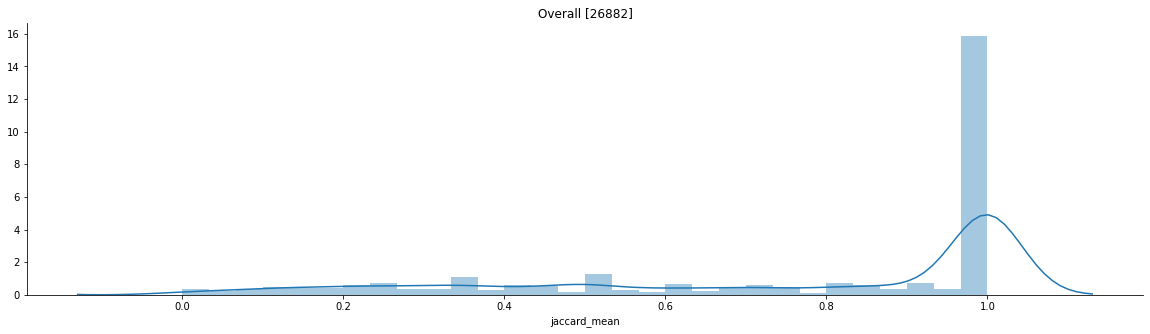

In [19]:
#@title
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(k_fold['jaccard_mean'], ax=ax).set_title(f"Overall [{len(k_fold)}]")
sns.despine()
plt.show()

## By sentiment

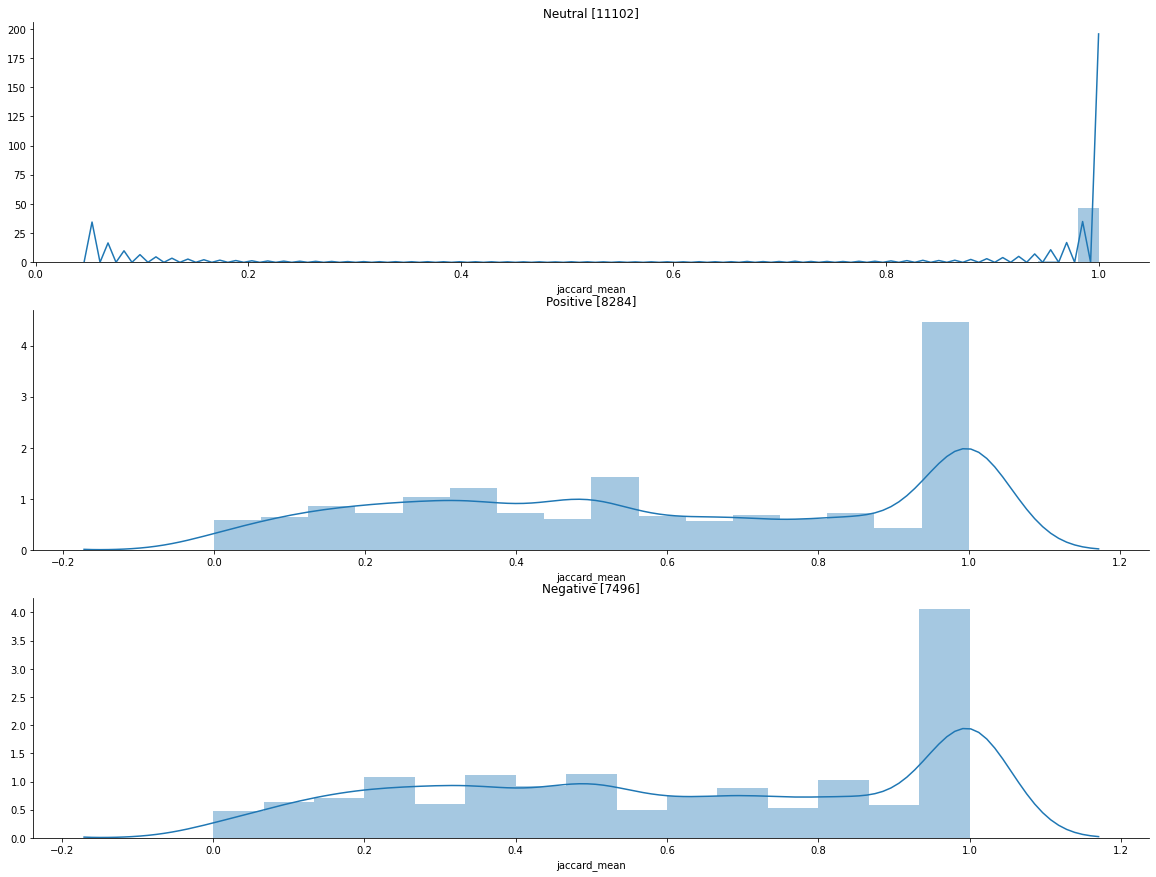

In [20]:
#@title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=False)
sns.distplot(k_fold[k_fold['sentiment'] == 'neutral']['jaccard_mean'], ax=ax1).set_title(f"Neutral [{len(k_fold[k_fold['sentiment'] == 'neutral'])}]")
sns.distplot(k_fold[k_fold['sentiment'] == 'positive']['jaccard_mean'], ax=ax2).set_title(f"Positive [{len(k_fold[k_fold['sentiment'] == 'positive'])}]")
sns.distplot(k_fold[k_fold['sentiment'] == 'negative']['jaccard_mean'], ax=ax3).set_title(f"Negative [{len(k_fold[k_fold['sentiment'] == 'negative'])}]")
sns.despine()
plt.show()

## By text token count

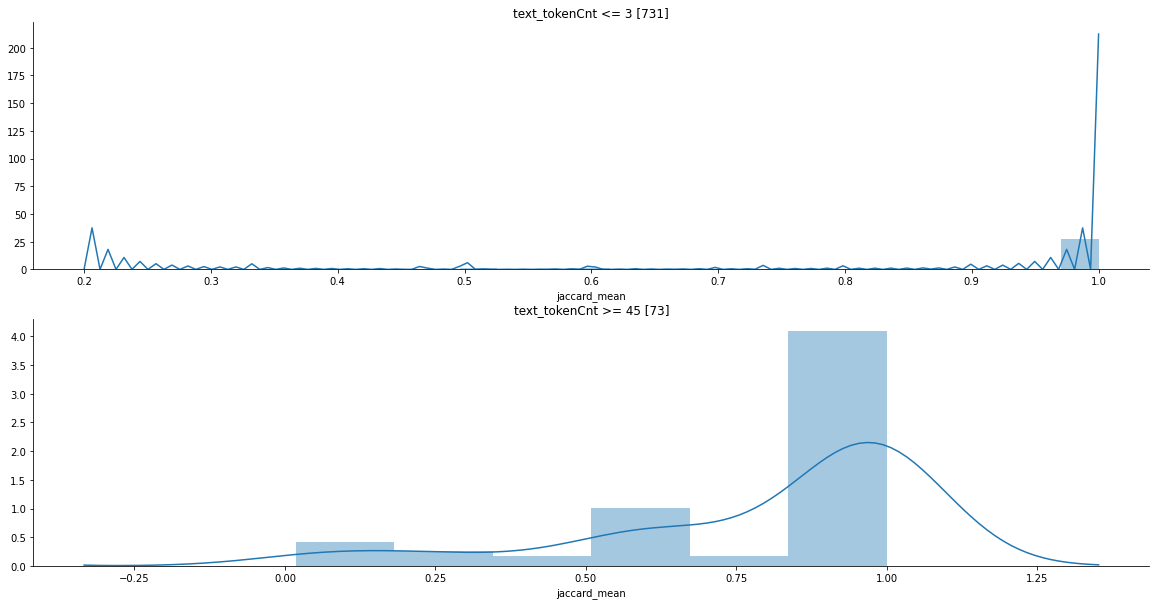

In [21]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold[k_fold['text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"text_tokenCnt <= 3 [{len(k_fold[k_fold['text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold[k_fold['text_tokenCnt'] >= 45]['jaccard_mean'], ax=ax2).set_title(f"text_tokenCnt >= 45 [{len(k_fold[k_fold['text_tokenCnt'] >= 45])}]")
sns.despine()
plt.show()

## By selected_text token count

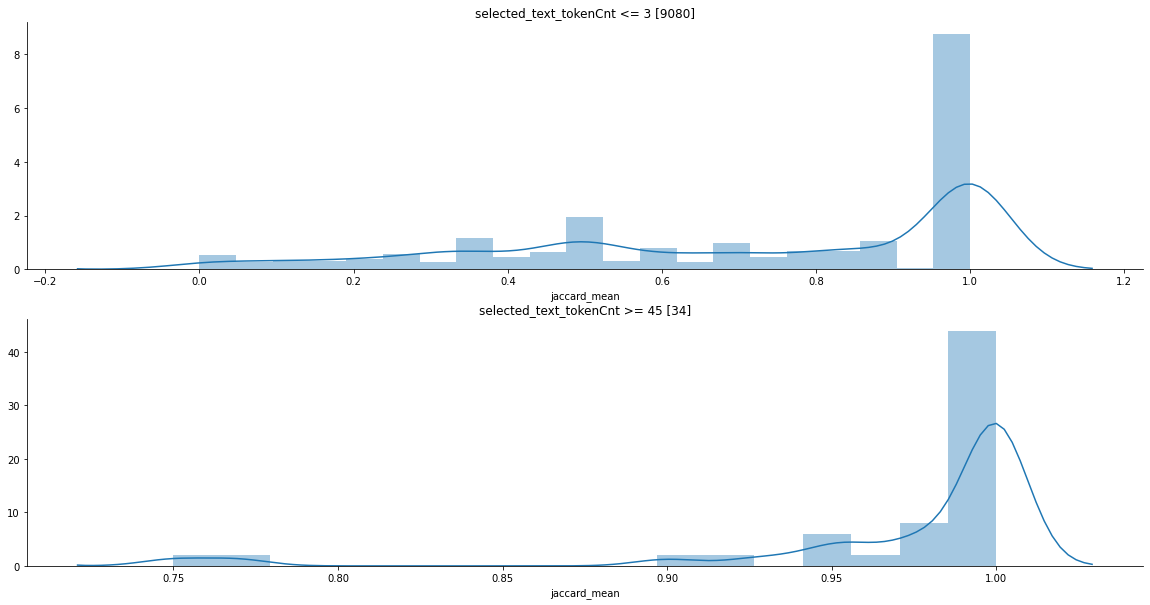

In [22]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold[k_fold['selected_text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"selected_text_tokenCnt <= 3 [{len(k_fold[k_fold['selected_text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold[k_fold['selected_text_tokenCnt'] >= 45]['jaccard_mean'], ax=ax2).set_title(f"selected_text_tokenCnt >= 45 [{len(k_fold[k_fold['selected_text_tokenCnt'] >= 45])}]")
sns.despine()
plt.show()